In [0]:
clinicaltrial_rdd = sc.textFile("/FileStore/tables/clinicaltrial_2021.csv")   #defining the main rdd

clinicaltrial_rdd.take(10)    #Return the first 10 elements of the rdd

Out[1]: ['Id|Sponsor|Status|Start|Completion|Type|Submission|Conditions|Interventions',
 'NCT02758028|The University of Hong Kong|Recruiting|Aug 2005|Nov 2021|Interventional|Apr 2016||',
 'NCT02751957|Duke University|Completed|Jul 2016|Jul 2020|Interventional|Apr 2016|Autistic Disorder,Autism Spectrum Disorder|',
 'NCT02758483|Universidade Federal do Rio de Janeiro|Completed|Mar 2017|Jan 2018|Interventional|Apr 2016|Diabetes Mellitus|',
 'NCT02759848|Istanbul Medeniyet University|Completed|Jan 2012|Dec 2014|Observational|May 2016|Tuberculosis,Lung Diseases,Pulmonary Disease|',
 'NCT02758860|University of Roma La Sapienza|Active, not recruiting|Jun 2016|Sep 2020|Observational [Patient Registry]|Apr 2016|Diverticular Diseases,Diverticulum,Diverticulosis|',
 'NCT02757209|Consorzio Futuro in Ricerca|Completed|Apr 2016|Jan 2018|Interventional|Apr 2016|Asthma|Fluticasone,Xhance,Budesonide,Formoterol Fumarate,Salmeterol Xinafoate',
 'NCT02752438|Ankara University|Unknown status|May 2016|Jul 2

In [0]:
#Transforming the main rdd to make each piece of information a separate element in the rdd
clinicaltrial_rdd1 = clinicaltrial_rdd.map(lambda line: line.split("|")).map(lambda values: [values[0], values[1], values[2], values[3], values[4], values[5], values[6], values[7], ""] if len(values) < 9 else [values[0], values[1], values[2], values[3], values[4], values[5], values[6], values[7], values[8]])

In [0]:
clinicaltrial_rdd1.take(5)     #checking the resulted rdd

Out[3]: [['Id',
  'Sponsor',
  'Status',
  'Start',
  'Completion',
  'Type',
  'Submission',
  'Conditions',
  'Interventions'],
 ['NCT02758028',
  'The University of Hong Kong',
  'Recruiting',
  'Aug 2005',
  'Nov 2021',
  'Interventional',
  'Apr 2016',
  '',
  ''],
 ['NCT02751957',
  'Duke University',
  'Completed',
  'Jul 2016',
  'Jul 2020',
  'Interventional',
  'Apr 2016',
  'Autistic Disorder,Autism Spectrum Disorder',
  ''],
 ['NCT02758483',
  'Universidade Federal do Rio de Janeiro',
  'Completed',
  'Mar 2017',
  'Jan 2018',
  'Interventional',
  'Apr 2016',
  'Diabetes Mellitus',
  ''],
 ['NCT02759848',
  'Istanbul Medeniyet University',
  'Completed',
  'Jan 2012',
  'Dec 2014',
  'Observational',
  'May 2016',
  'Tuberculosis,Lung Diseases,Pulmonary Disease',
  '']]

In [0]:
from pyspark.sql.types import *           #Defining a schema for the dataframe 

mySchema = \
StructType([
StructField ("Id", StringType()) ,
StructField ("Sponsor", StringType()) ,
StructField ("Status", StringType()) ,
StructField ("Start", StringType()) ,
StructField ("Completion", StringType()) ,            #the dataframe contains 9 columns
StructField ("Type", StringType()) ,
StructField ("Submission", StringType()) ,
StructField ("Conditions", StringType()) ,
StructField ("Interventions", StringType())])

In [0]:
clinicaltrial_df = spark.createDataFrame(clinicaltrial_rdd1, mySchema)       #create the dataframe

In [0]:
clinicaltrial_df.show()             #display the contents of the dataframe

+-----------+--------------------+--------------------+--------+----------+--------------------+----------+--------------------+--------------------+
|         Id|             Sponsor|              Status|   Start|Completion|                Type|Submission|          Conditions|       Interventions|
+-----------+--------------------+--------------------+--------+----------+--------------------+----------+--------------------+--------------------+
|         Id|             Sponsor|              Status|   Start|Completion|                Type|Submission|          Conditions|       Interventions|
|NCT02758028|The University of...|          Recruiting|Aug 2005|  Nov 2021|      Interventional|  Apr 2016|                    |                    |
|NCT02751957|     Duke University|           Completed|Jul 2016|  Jul 2020|      Interventional|  Apr 2016|Autistic Disorder...|                    |
|NCT02758483|Universidade Fede...|           Completed|Mar 2017|  Jan 2018|      Interventional|  Ap

In [0]:
num_distinct_studies = clinicaltrial_df.filter("Id != 'Id'").select('Id').distinct().count()  #checking the number of distinct studies

print(f'Number of distinct studies is {num_distinct_studies}.')

Number of distinct studies is 387261.


In [0]:
clinicaltrial_df = spark.read.csv("/FileStore/tables/clinicaltrial_2021.csv", header=True, inferSchema=True, sep='|') #read the clinical trial file, specifying the header and delimeter

clinicaltrial_df = clinicaltrial_df.filter(clinicaltrial_df.Type != 'Type') #filter out the type column

types_count_clinicaltrial_df = clinicaltrial_df.groupBy("Type").count().sort("count", ascending=False) #group by type column and count   each distinct value in the rows sorted in descending order

types_count_clinicaltrial_df.show()

+--------------------+------+
|                Type| count|
+--------------------+------+
|      Interventional|301472|
|       Observational| 77540|
|Observational [Pa...|  8180|
|     Expanded Access|    69|
+--------------------+------+



In [0]:
clinicaltrial_df = spark.read.csv("/FileStore/tables/clinicaltrial_2021.csv", header=False, inferSchema=True, sep='|')

from pyspark.sql.functions import split, explode
conditions_df = clinicaltrial_df.select(explode(split("_c7", ",\s*")).alias("Conditions")) #split values in the 7th column

top_conditions_df = conditions_df.groupBy("Conditions").count().orderBy("count", ascending=False).limit(5) #group by conditions and count the numberof times each condition appears

print("Top 5 conditions with their frequencies :")
top_conditions_df.show()


Top 5 conditions with their frequencies :
+-----------------+-----+
|       Conditions|count|
+-----------------+-----+
|        Carcinoma|13389|
|Diabetes Mellitus|11080|
|        Neoplasms| 9371|
| Breast Neoplasms| 8640|
|         Syndrome| 8032|
+-----------------+-----+



In [0]:
from pyspark.sql.types import *

mySchema = StructType([
    StructField("Company", StringType()),
    StructField("Parent_Company", StringType()),
    StructField("Penalty_Amount", StringType()),
    StructField("Subtraction_From_Penalty", StringType()),
    StructField("Penalty_Amount_Adjusted_For_Eliminating_Multiple_Counting", StringType())
])

pharma_rdd = sc.textFile("/FileStore/tables/pharma.csv") \
             .map(lambda line: line.split(",")) \
             .map(lambda values: (values[0], values[1], (values[2]), (values[3]), (values[4])))

pharma_df = spark.createDataFrame(pharma_rdd, mySchema)
pharma_df.show(10)

+--------------------+--------------------+--------------------+------------------------+---------------------------------------------------------+
|             Company|      Parent_Company|      Penalty_Amount|Subtraction_From_Penalty|Penalty_Amount_Adjusted_For_Eliminating_Multiple_Counting|
+--------------------+--------------------+--------------------+------------------------+---------------------------------------------------------+
|           "Company"|    "Parent_Company"|    "Penalty_Amount"|    "Subtraction_From...|                                     "Penalty_Amount_A...|
|"Abbott Laborator...|"Abbott Laborator...|                 "$5|                     475|                                                     000"|
|"Abbott Laborator...|            "AbbVie"|                 "$1|                     500|                                                      000|
|"Abbott Laborator...|            "AbbVie"|               "$126|                     500|                       

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Create Spark session
spark = SparkSession.builder.appName("ClinicalTrialAnalysis").getOrCreate()

# Read clinical trial dataset into a DataFrame
clinicaltrial_df = spark.read.csv("/FileStore/tables/clinicaltrial_2021.csv", header=True, inferSchema=True, sep='|')

# Read pharma dataset into a DataFrame
pharma_df = spark.read.csv("/FileStore/tables/pharma.csv", header=True, inferSchema=True, sep=',')

# Extract list of pharmaceutical companies
pharmaceutical_companies = pharma_df.select("Parent_Company").rdd.flatMap(lambda x: x).collect()

# Filter out sponsor in clinical trial that contain pharmaceutical companies
non_pharma_sponsors_df = clinicaltrial_df.filter(~col("Sponsor").isin(pharmaceutical_companies))

# Group by sponsor and count number of trials
sponsor_counts = non_pharma_sponsors_df.groupBy("Sponsor").count()

# Order by count in descending order
sponsor_counts = sponsor_counts.orderBy(col("count").desc())

# Select top 10 sponsors with highest counts
top_10_sponsors = sponsor_counts.limit(10)

# Display the results
top_10_sponsors.show()

+--------------------+-----+
|             Sponsor|count|
+--------------------+-----+
|National Cancer I...| 3218|
|M.D. Anderson Can...| 2414|
|Assistance Publiq...| 2369|
|         Mayo Clinic| 2300|
|Merck Sharp & Doh...| 2243|
|   Assiut University| 2154|
|Novartis Pharmace...| 2088|
|Massachusetts Gen...| 1971|
|    Cairo University| 1928|
|   Hoffmann-La Roche| 1828|
+--------------------+-----+



In [0]:
# Read clinical trial dataset into a DataFrame
clinicaltrial_df = spark.read.csv("/FileStore/tables/clinicaltrial_2021.csv", header=True, inferSchema=True, sep='|')

#Select the "Status" and "Completion" columns from the original DataFrame and Add a new column "Months" to the DataFrame `clinicaltrial_df2`, which contains the first element of the result of splitting the "Completion" column on the space character
clinicaltrial_df2 = clinicaltrial_df.select("Status", "Completion").withColumn("Months",split(col("Completion")," ").getItem(0))

#Add a new column "Years" to the DataFrame `clinicaltrial_df2`, which contains the second element of the result of splitting the "Completion" column on the space character
clinicaltrial_df2 = clinicaltrial_df2.withColumn("Years", split(col("Completion"), " ").getItem(1))

clinicaltrial_df2.display()


Status,Completion,Months,Years
Recruiting,Nov 2021,Nov,2021
Completed,Jul 2020,Jul,2020
Completed,Jan 2018,Jan,2018
Completed,Dec 2014,Dec,2014
"Active, not recruiting",Sep 2020,Sep,2020
Completed,Jan 2018,Jan,2018
Unknown status,Jul 2017,Jul,2017
Unknown status,Nov 2019,Nov,2019
Completed,Jul 2017,Jul,2017
Completed,Jan 2021,Jan,2021


In [0]:
from pyspark.sql.functions import col, udf, to_date, date_format
from pyspark.sql.types import IntegerType

# Define a custom function to map month abbreviations to numbers
def map_month_to_number(month):
    month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    return month_order.index(month) + 1

# Define the custom function as a UDF
udf_map_month_to_number = udf(map_month_to_number, IntegerType())

# Convert the "Months" column to a date format with a fixed year and day
clinicaltrial_df2 = clinicaltrial_df2.withColumn("MonthDate", to_date(date_format(col("Months"), "MMM-yyyy"), "yyyy-MM-dd"))

# Sort the "Months" column by the custom order
Number_of_completed_studies = clinicaltrial_df2.filter((col("Years") == "2021") & (col("Status") == "Completed")).groupBy("Months").count().orderBy(udf_map_month_to_number(col("Months")))

# Rename the "Months" column to "Month" and display the result
Number_of_completed_studies = Number_of_completed_studies.withColumnRenamed("Months", "Month")
Number_of_completed_studies.display()


Month,count
Jan,1131
Feb,934
Mar,1227
Apr,967
May,984
Jun,1094
Jul,819
Aug,700
Sep,528
Oct,187


In [0]:
from pyspark.sql.functions import count

# Load clinical trial and pharma datasets into PySpark DataFrame
clinicaltrial_df = spark.read.csv("/FileStore/tables/clinicaltrial_2021.csv", header=True, inferSchema=True, sep='|')
pharma_df = spark.read.csv("/FileStore/tables/pharma.csv", header=True, inferSchema=True)

# Join datasets on Sponsor/Parent Company column
joined_df = clinicaltrial_df.join(pharma_df, clinicaltrial_df['Sponsor'] == pharma_df['Parent_Company'], "inner")

# Group by Parent Company and count the number of studies
num_studies_by_company = joined_df.groupBy('Parent_Company').agg(count('Id').alias('num_studies')).orderBy('num_studies', ascending=False)

# Show top 10 companies with the most studies
num_studies_by_company.limit(10).show()


+--------------------+-----------+
|      Parent_Company|num_studies|
+--------------------+-----------+
|              Pfizer|     187795|
|     GlaxoSmithKline|     118230|
|         AstraZeneca|      64584|
|Bristol-Myers Squibb|      45669|
|              Sanofi|      35672|
|Boehringer Ingelheim|      27538|
|            Novartis|      26910|
|              AbbVie|      25725|
|               Amgen|      14880|
|Teva Pharmaceutic...|       4240|
+--------------------+-----------+



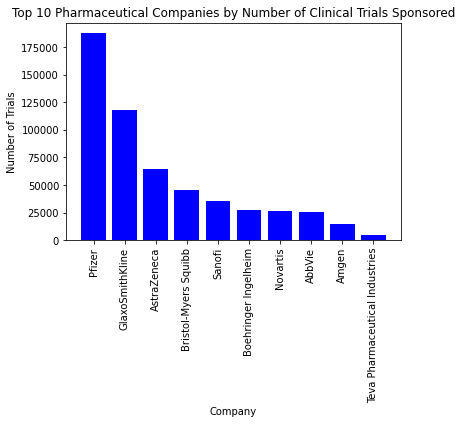

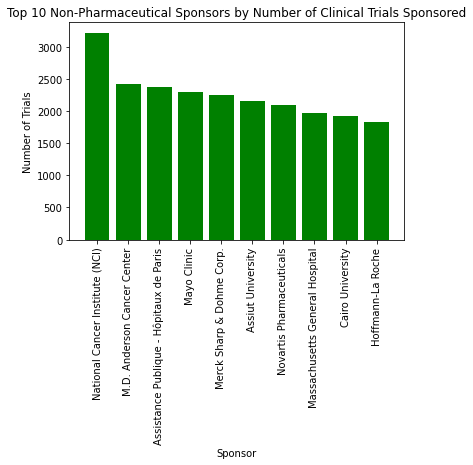

In [0]:
import matplotlib.pyplot as plt

# Define the data to be plotted
pharma_counts = num_studies_by_company.limit(10).toPandas()
non_pharma_counts = sponsor_counts.limit(10).toPandas()

# Create a bar chart for the top pharmaceutical companies
plt.bar(pharma_counts['Parent_Company'], pharma_counts['num_studies'], color='blue')
plt.title('Top 10 Pharmaceutical Companies by Number of Clinical Trials Sponsored')
plt.xlabel('Company')
plt.ylabel('Number of Trials')
plt.xticks(rotation=90)
plt.show()

# Create a bar chart for the top non-pharmaceutical sponsors
plt.bar(non_pharma_counts['Sponsor'], non_pharma_counts['count'], color='green')
plt.title('Top 10 Non-Pharmaceutical Sponsors by Number of Clinical Trials Sponsored')
plt.xlabel('Sponsor')
plt.ylabel('Number of Trials')
plt.xticks(rotation=90)
plt.show()
